<a href="https://colab.research.google.com/github/witcherrie/graphdom/blob/main/deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importy

In [70]:
!pip install torch_geometric

In [71]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np
import networkx as nx
import pandas as pd
from torch_geometric.utils import to_networkx
import networkx as nx
import random
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns

### Import i przygotowanie danych


In [72]:
df = pd.read_excel("properties.xls")
df['is_duplicate'] = df.duplicated(subset=["latitude", "longitude"], keep=False)
df_unique = df[~df['is_duplicate']].copy()
df_sample = df_unique.sample(n=3000, random_state=42).reset_index(drop=True)
df_sample.head()

,OBJECTID,price,m2,rooms_number,market,building_type,floor_no,building_floor,windows_type,heating,...,longitude,building_material,metro_distance,bust_tram_distance,rail_distance,centre_travel_time,park_distance,uniqueID,district_numerical,is_duplicate
0,1929,1098000.0,57.00,4,1,1,3,7,1,5,...,20.988997,9,831.40,33.07,1224.47,9,580.0,1934,9,False
1,1519,880000.0,45.43,2,1,0,0,4,1,5,...,20.909935,8,188.06,134.25,3308.54,22,677.0,1524,1,False
2,2417,1999000.0,75.70,3,1,6,2,3,1,5,...,21.059330,1,1625.64,3.46,1490.05,9,491.0,2425,6,False
3,2313,1255000.0,52.44,2,1,6,3,4,1,5,...,21.034454,1,1395.94,78.14,825.77,7,5.0,2320,9,False
4,6259,560000.0,20.97,1,1,1,2,10,1,5,...,20.956830,9,904.63,120.57,422.32,13,528.0,6280,17,False


In [89]:
df_sample.to_csv("df_sample.csv", index=False)

In [ ]:
df_sample = pd.read_csv("df_sample.csv")

In [73]:
features = df_sample[["price", "m2", "rooms_number", "market", "building_type", "floor_no", "building_floor", "windows_type",
               "heating", "build_year", "construction", "rent", "building_ownership", "building_material",
               "metro_distance", "bust_tram_distance", "rail_distance", "centre_travel_time", "park_distance" ]].values
coords = df_sample[["latitude", "longitude"]].values

### Tworzenie grafu


In [74]:
edge_index = []
weights = []

for i in range(len(coords)):
    for j in range(i + 1, len(coords)):
        distance = np.linalg.norm(coords[i] - coords[j])
        if distance < 0.08:
            edge_index.append([i, j])
            weights.append(distance)

In [75]:
weights = np.array(weights)

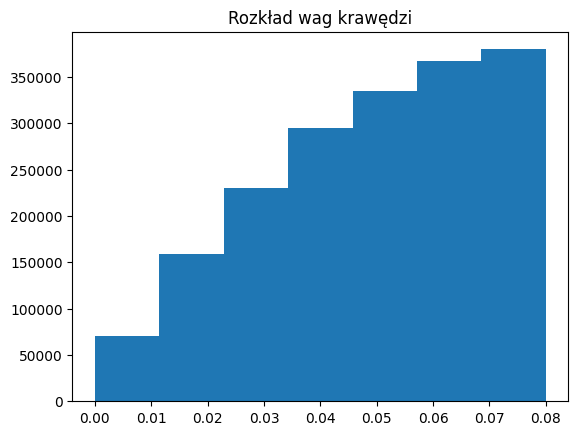

In [76]:
plt.hist(weights, bins=7)
plt.title("Rozkład wag krawędzi")
plt.show()

In [77]:
print("Min waga:", min(weights))
print("Max waga:", max(weights))

Min waga: 1.1000018673712475e-09
Max waga: 0.07999998496458006


### Przykładowy podgraf

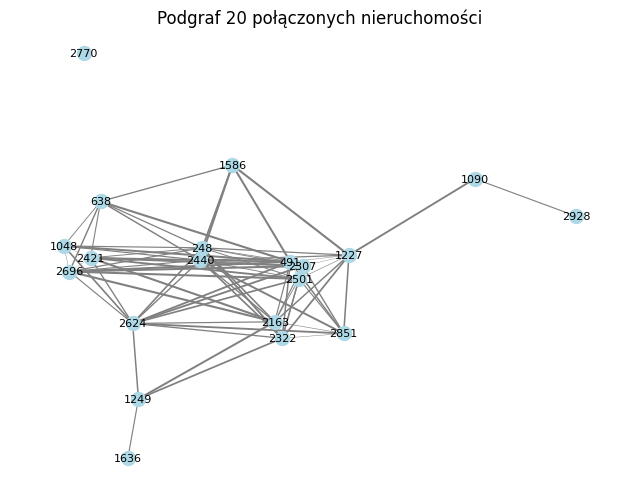

Liczba wierzchołków: 20
Liczba krawędzi: 81


In [78]:
edge_array = np.array(edge_index)
weights_array = np.array(weights)
if edge_array.shape[0] == 2:
    edge_array = edge_array.T

G = nx.Graph()
for (i, j), w in zip(edge_array, weights_array):
    G.add_edge(i, j, weight=w)

components = list(nx.connected_components(G))
largest_component = max(components, key=len)

sample_nodes = random.sample(list(largest_component), 20)
G_sub = G.subgraph(sample_nodes).copy()

pos = {node: coords[node] for node in G_sub.nodes}

edges = G_sub.edges()
weights_sub = [G_sub[u][v]['weight'] for u, v in edges]

if len(weights_sub) == 0:
    widths = []
else:
    min_w = min(weights_sub)
    max_w = max(weights_sub)
    if max_w == min_w:
        widths = [2 for _ in weights_sub]
    else:
        widths = [0.01 + 1.5 * (w - min_w) / (max_w - min_w) for w in weights_sub]


plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_sub, pos, node_size=100, node_color='lightblue')
nx.draw_networkx_edges(G_sub, pos, width=widths, edge_color='gray')
nx.draw_networkx_labels(G_sub, pos, font_size=8)

plt.title("Podgraf 20 połączonych nieruchomości")
plt.axis('off')
plt.show()

print("Liczba wierzchołków:", len(G_sub.nodes))
print("Liczba krawędzi:", len(G_sub.edges))


### Przygotowanie modelu GCN



In [79]:
features = StandardScaler().fit_transform(features)
x = torch.tensor(features, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(weights, dtype=torch.float)
data = Data(x=x, edge_index=edge_index, edge_weight=edge_weight)
print(data)

Data(x=[3000, 19], edge_index=[2, 1836196], edge_weight=[1836196])


In [80]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_weight
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return x

In [81]:
model = GCN(in_channels=19, hidden_channels=16, out_channels=19)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Trening modelu

In [82]:
losses = []
model.train()
for epoch in range(50):
    optimizer.zero_grad()
    out = model(data)
    loss = torch.mean(torch.norm(out - data.x, dim=1))
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

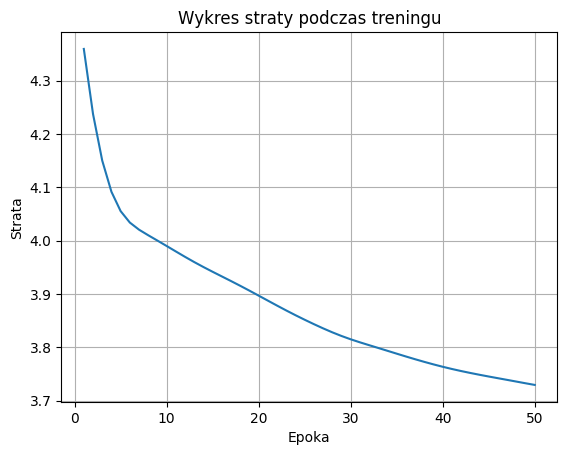

In [83]:
plt.plot(range(1, 51), losses)
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.title('Wykres straty podczas treningu')
plt.grid(True)
plt.show()

### Klasteryzacja embeddingów

In [84]:
model.eval()
embeddings = model(data).detach().numpy()

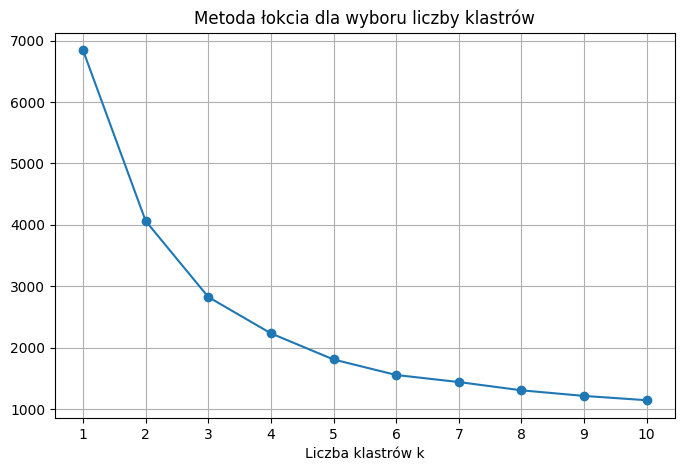

In [85]:
inertias = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Liczba klastrów k')
plt.title('Metoda łokcia dla wyboru liczby klastrów')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [86]:
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(embeddings)

print("Silhouette score:", silhouette_score(embeddings, labels))

Silhouette score: 0.41539165


In [87]:
df_sample['labels'] = labels

### Wizualizacja

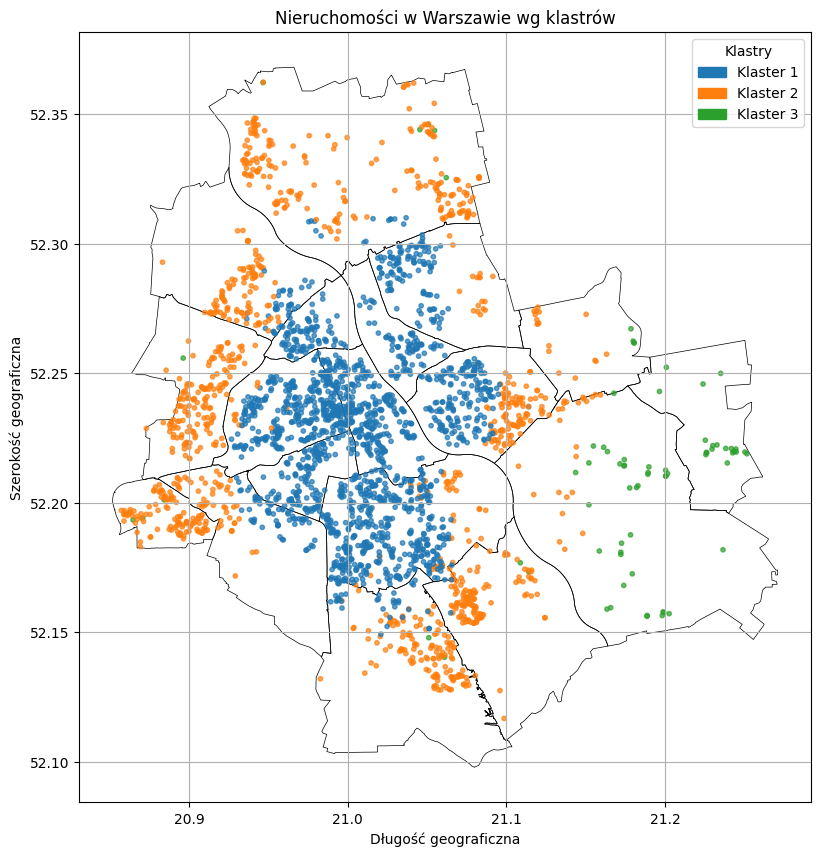

In [88]:
districts = gpd.read_file("/content/dzielnice miasta st_ Warszawy.shp")
districts = districts.to_crs(epsg=4326)

df_sample['geometry'] = df_sample.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf_props = gpd.GeoDataFrame(df_sample, geometry='geometry', crs='EPSG:4326')

palette = sns.color_palette("tab10", 3)
cmap = ListedColormap(palette)
fig, ax = plt.subplots(figsize=(10, 10))


districts.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)


gdf_props.plot(ax=ax, column='labels', cmap=cmap, markersize=10, alpha=0.7, legend=False)
handles = [mpatches.Patch(color=palette[i], label=f'Klaster {i+1}') for i in range(3)]
plt.legend(handles=handles, title='Klastry')

plt.title("Nieruchomości w Warszawie wg klastrów")
plt.xlabel("Długość geograficzna")
plt.ylabel("Szerokość geograficzna")
plt.grid(True)
plt.show()